In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
from sklearn.datasets import dump_svmlight_file
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

svm_train_fn='svmlight_train_oct.dat'
svm_val_fn='svmlight_val_oct.dat'
svm_test_fn='svmlight_test_oct.dat'

tr_fn='oct_train.csv'
val_fn='oct_val.csv'
test_fn='oct_test.csv'

In [4]:
dtrain = xgb.DMatrix(svm_light_train_fn)
dval = xgb.DMatrix(svm_light_val_fn)
params = {
    "eta": 0.001,
    "objective": "binary:logistic",
    "subsample": 0.7,
    "eval_metric": ["logloss"]
}
model = xgb.train(params, dtrain, 5000, evals = [(dval, "test")], verbose_eval=500, early_stopping_rounds=20)

[13:43:00] 2199x128 matrix with 281472 entries loaded from /home/parmita/glaucoma_results/gl_nm/OCT_data/densenet_16/svmlight_train_dn16.dat
[13:43:00] 177x128 matrix with 22644 entries loaded from /home/parmita/glaucoma_results/gl_nm/OCT_data/densenet_16/svmlight_val_dn16.dat
[0]	test-logloss:0.693187
Will train until test-logloss hasn't improved in 20 rounds.
Stopping. Best iteration:
[87]	test-logloss:0.691824



In [5]:
explainer = shap.TreeExplainer(model)
tr=pd.read_table(tr_fn)
val=pd.read_table(val_fn)
te=pd.read_table(test_fn)
x=pd.concat((tr,val),axis=0)
x=pd.concat((x,te))
tr_name=x['pid'].astype(str)+'_'+x['eye'].astype(str)+'_'+x['d1'].astype(str)+'_'+x['d2'].astype(str)
x.pop('pid')
x.pop('eye')
x.pop('d1')
x.pop('d2')
y=x.pop('l')
shap_values = explainer.shap_values(x)

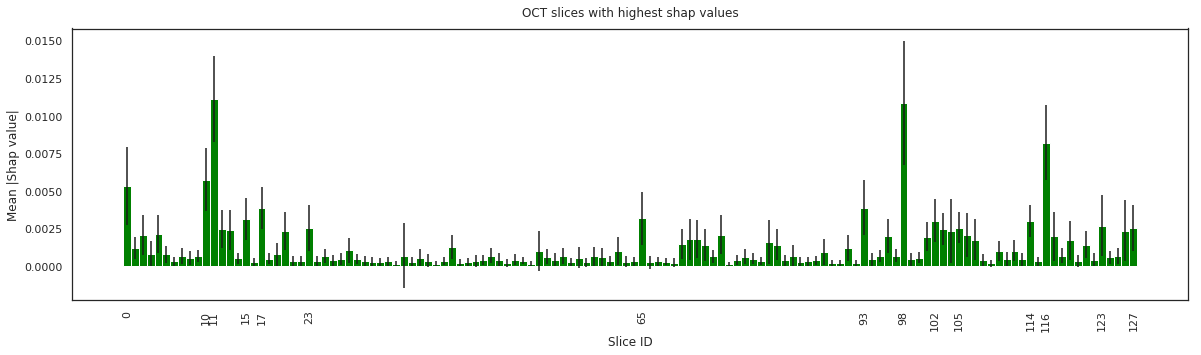

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white')

m_shap=np.mean(np.absolute(shap_values),axis=0)
std_shap=np.std(np.absolute(shap_values),axis=0)
names=x.columns
sv=pd.DataFrame(m_shap)
sv['names']=names
sv['std']=std_shap
sv.columns=['shap_value','names','std']
sv_l=sv.nlargest(15,['shap_value'])

plt.figure(figsize=(20,5))
barlist=plt.bar(sv['names'].values,sv['shap_value'].values, yerr=sv['std'].values, color='green',width=1.0)

plt.xlabel('Slice ID')
plt.ylabel("Mean |Shap value|")
plt.title("OCT slices with highest shap values")
plt.xticks(sv_l['names'].values,sv_l['names'].values, rotation=90)

sns.set(style='white')

(2373, 128)


/home/parmita/venv/lib/python3.5/site-packages/seaborn/matrix.py:268: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed two minor releases later. Use Tick.label1 instead.
  fontsize = tick.label.get_size()


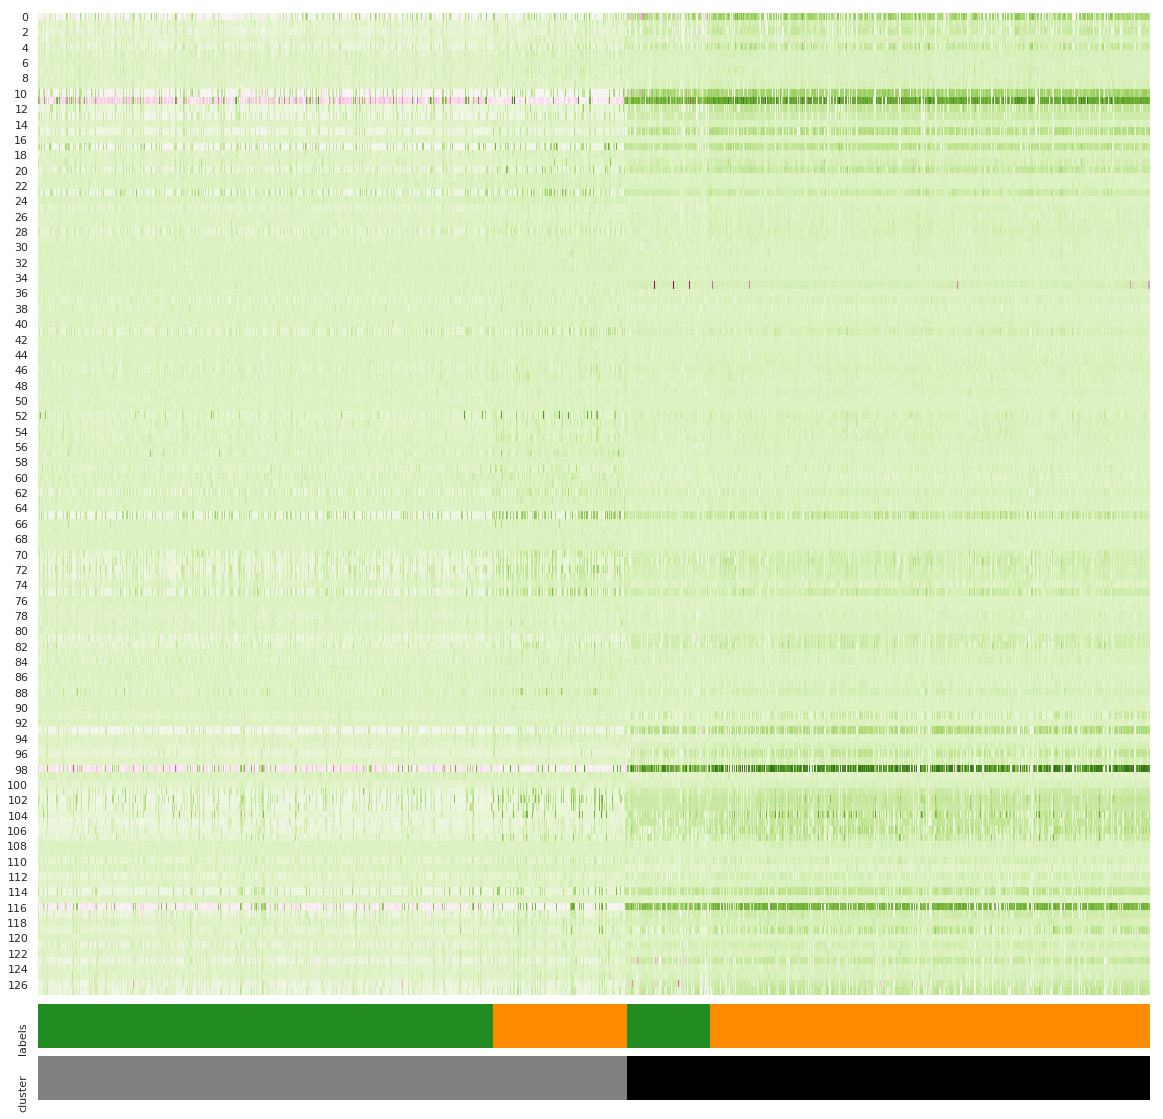

In [7]:
from sklearn.cluster import SpectralClustering
mm = SpectralClustering(n_clusters=2,
assign_labels="discretize", random_state=47)
mm.fit(shap_values)
d=pd.DataFrame(shap_values)
mm.fit(d)
d['cluster']=mm.labels_
d['labels']=y.values
colors_nmgl=['forestgreen','darkorange'] #for progress to glaucoma#1f78b4
colors_clus=['grey','black']
fig = plt.figure(figsize=(21,20))
ax1 = plt.subplot2grid((21,20), (0,0), colspan=19, rowspan=19)
ax2 = plt.subplot2grid((21,20), (19,0), colspan=19, rowspan=1)
ax3 = plt.subplot2grid((21,20), (20,0), colspan=19, rowspan=1)
d_c=d.sort_values(by=['cluster','labels'])

sub=d_c.iloc[:,:-2]
print(sub.shape)
c=d_c[['cluster']]
l=d_c[['labels']]
sns.heatmap(sub.T,ax=ax1,cmap='PiYG',cbar=False,xticklabels=False)
sns.heatmap(l.T,ax=ax2,cmap=colors_nmgl,cbar=False,xticklabels=False)#labels

sns.heatmap(c.T, ax=ax3,  cmap=colors_clus, cbar=False, xticklabels=False)#two clusters